Investigate randomization effects of different layers

##### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
import os
sys.path.insert(0, os.getcwd())

In [3]:
import torch 
import pickle
import nibabel

from jrieke.utils import load_nifti, save_nifti
from innvestigator import InnvestigateModel
from settings import settings
from utils import load_data, scale_mask
from jrieke import interpretation
from nmm_mask_areas import all_areas

import numpy as np
import pickle
import jrieke.models as models


for k in settings.keys():
    print("Adding " + k + " to namespace")
    globals()[k] = settings[k]

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Adding model_path to namespace
Adding data_path to namespace
Adding ADNI_DIR to namespace
Adding train_h5 to namespace
Adding val_h5 to namespace
Adding holdout_h5 to namespace
Adding binary_brain_mask to namespace
Adding nmm_mask_path to namespace
Adding nmm_mask_path_scaled to namespace


In [4]:
data_path = "/analysis/ritter/projects/Methods/LRP/data/rieke-copy1/2Node_trial0/randomization/"

## Load model

In [5]:
device = 2

In [6]:
# randomize
def randomize_layers(net, layer=0, incr=True):
    """
    parameters:
        net: PyTorch Module instance
        layer: Layer number in net.parameters.
        incr: If set to True randomize all layers starting from selected
            layer until the final layer. If set to False only randomize
            the selected layer.
    """
    
    i = 0
    for name, mod in net.named_modules():
        if i == layer:
            if incr: 
                print("Randomizing from layer %s until the end." % name)
            else:
                print("Randomizing layer %s only." % name)
            reset_module(mod)
        if incr:
            if i > layer:
                reset_module(mod)
        i += 1
                
def reset_module(mod):
    resetter = getattr(mod, "reset_parameters", None)
    if callable(resetter):
        resetter()
            

In [7]:
def get_randomized_model(layer=0, incr=True):
    net = models.ClassificationModel3D_2Node().cuda(device)
    net.load_state_dict(torch.load(model_path,
                                  map_location='cpu'))
    net.eval()
    net = torch.nn.Sequential(net, torch.nn.Softmax(dim=1))
    randomize_layers(net, layer=layer, incr=incr)
    return net

In [8]:
randomization_points = [15, 14, 11, 8, 2]
model_list = [get_randomized_model(layer=point, incr=True) for point in randomization_points]

Randomizing from layer 0.dense_2 until the end.
Randomizing from layer 0.dense_1 until the end.
Randomizing from layer 0.Conv_4 until the end.
Randomizing from layer 0.Conv_3 until the end.
Randomizing from layer 0.Conv_1 until the end.


In [9]:
trained_model = models.ClassificationModel3D_2Node().cuda(device)
trained_model.load_state_dict(torch.load(model_path,
                              map_location='cpu'))
trained_model.eval()
trained_model = torch.nn.Sequential(trained_model, torch.nn.Softmax(dim=1))

model_list.insert(0, trained_model)

In [10]:
inn_models = []
for model in model_list:
    inn_model = InnvestigateModel(model, lrp_exponent=1,
                                  method="b-rule",
                                  beta=0, epsilon=1e-6).cuda(device)
    inn_model.eval()
    inn_models.append(inn_model)

Hence, if in any layer only positive contributions exist, the overall relevance will not be conserved.

Hence, if in any layer only positive contributions exist, the overall relevance will not be conserved.

Hence, if in any layer only positive contributions exist, the overall relevance will not be conserved.

Hence, if in any layer only positive contributions exist, the overall relevance will not be conserved.

Hence, if in any layer only positive contributions exist, the overall relevance will not be conserved.

Hence, if in any layer only positive contributions exist, the overall relevance will not be conserved.



## Load ADNI Data

In [11]:
import h5py

In [12]:
def min_max_normalization(subset):
    for i in range(len(subset)):
        subset[i] -= np.min(subset[i])
        subset[i] /= np.max(subset[i])
    return subset
    
def load_data(skip_train=True, skip_val=True, skip_test=False, dtype=np.float32):
    """ Load hdf5 files and extract columns. """
    X_train, y_train, X_val, y_val, X_holdout, y_holdout = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    # train
    if not skip_train:
        train_h5_ = h5py.File(train_h5, 'r')
        X_train, y_train = train_h5_['X'], train_h5_['y']
        X_train = np.expand_dims(np.array(X_train, dtype=dtype), 1)
        X_train = min_max_normalization(X_train)
        y_train = np.array(y_train)
        print("Total training set length: {}".format(len(y_train)))
        print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
        print("Number of AD patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))
    if not skip_val:
        # val
        val_h5_ = h5py.File(val_h5, 'r')
        X_val, y_val = val_h5_['X'], val_h5_['y']
        X_val = np.expand_dims(np.array(X_val, dtype=dtype), 1)
        X_val = min_max_normalization(X_val)
        y_val = np.array(y_val)
        print("Total validation set length: {}".format(len(y_val)))
    if not skip_test:
        # test
        holdout_h5_ = h5py.File(holdout_h5, 'r')
        X_holdout, y_holdout = holdout_h5_['X'][:5], holdout_h5_['y'][:5] # Note: load only first 5 samples
        X_holdout = np.expand_dims(np.array(X_holdout, dtype=dtype), 1)
        X_holdout = min_max_normalization(X_holdout)
        y_holdout = np.array(y_holdout)
        print("Total test set length: {}".format(len(y_holdout)))
   
    return X_train, y_train, X_val, y_val, X_holdout, y_holdout


In [13]:
X_train, y_train, X_val, y_val, X_holdout, y_holdout = load_data()

image_shape = X_holdout.shape[1:-1]

Total test set length: 5


## Load mask

In [14]:
mri_shape = X_holdout.shape[2:]

if False:
    neuromorph_map = nibabel.load(nmm_mask_path).get_data()
    nmm_mask = scale_mask(neuromorph_map, mri_shape)
    save_nifti(nmm_mask_path_scaled, nmm_mask)
else:
    nmm_mask = load_nifti(nmm_mask_path_scaled)

# all_areas holds the area name and a tuple with the minimum 
# idx in the NMM mask and the maximum idx in the NMM mask belonging to that area
area_masks = {k: None for k in all_areas.keys()}
for name, (min_idx, max_idx) in all_areas.items():
    area_mask = np.zeros(mri_shape)
    area_mask[np.logical_and(nmm_mask>=min_idx, nmm_mask<=max_idx)] = 1
    area_masks[name] = area_mask

## Run LRP

In [15]:
def run_LRP(net, image_tensor):
    return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=1)

#####  Run evaluation

In [16]:
image_idx = 1

In [17]:
maps = []
ad_score_list = []

for inn_model in inn_models:
    image_tensor = torch.Tensor(X_holdout[image_idx][None]).cuda(device)
    AD_score, LRP_map = run_LRP(inn_model, image_tensor)
    AD_score = AD_score[0][1].detach().cpu().numpy()
    LRP_map = LRP_map.detach().numpy().squeeze()
    maps.append(LRP_map)
    ad_score_list.append(AD_score)

In [18]:
ad_score_list

[array(0.9998939, dtype=float32),
 array(0.86047125, dtype=float32),
 array(0.56396496, dtype=float32),
 array(0.5038336, dtype=float32),
 array(0.47324258, dtype=float32),
 array(0.47766766, dtype=float32)]

In [19]:
y_holdout[image_idx]

1

## Plotting individual heatmaps

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy
%matplotlib inline

In [21]:

def plot_idv_brain(heat_map, brain_img, ref_scale, fig=None, ax=None, 
                  x_idx=slice(0, mri_shape[0]), y_idx=slice(0, mri_shape[1]), z_idx=slice(0, mri_shape[2]),
                  vmin=90, vmax=99.9, set_nan=True, cmap=None):

    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(8, 8))
    
    img = deepcopy(heat_map)
    if set_nan:
        img[nmm_mask==0]=np.nan
    if cmap is None:
        cmap = mcolors.LinearSegmentedColormap.from_list(name='alphared',
                                                  colors=[(1, 0, 0, 0),
                                                         "darkred", "red", "darkorange", "orange", "yellow"],
                                                  N=5000)
        
    #if brain_img is not None:
    #    ax.imshow(brain_img[x_idx, y_idx, z_idx].T, cmap="Greys")

    vmin_val, vmax_val = np.percentile(ref_scale, vmin), np.percentile(ref_scale, vmax)
    im = ax.imshow(img[x_idx, y_idx, z_idx].T, cmap=cmap, 
               vmin=vmin_val, vmax=vmax_val, interpolation="gaussian")
       
    ax.axis('off')
    plt.gca().invert_yaxis()
    
    fig.tight_layout()
    fig.subplots_adjust(right=0.8)

    cbar_ax = fig.add_axes([0.8, 0.15, 0.025, 0.7])
    cbar = fig.colorbar(im, shrink=0.5, ticks=[vmin, vmax], cax=cbar_ax)
    cbar.set_ticks([vmin_val, vmax_val])
    cbar.ax.set_yticklabels(['{0:.1f}%'.format(vmin), '{0:.1f}%'.format(vmax)], fontsize=14)
    cbar.set_label('Percentile of  average AD patient values\n', rotation=270, fontsize=14)
    return fig, ax


In [22]:
print(list(inn_models[0].named_modules())[16][0])
list(list(inn_models[0].named_modules())[16][1].parameters())

model.0.dense_2


[Parameter containing:
 tensor([[ 5.2714e-02, -5.8508e-02,  7.8167e-03,  3.6315e-02,  1.6630e-02,
           8.7848e-02,  3.1059e-02,  9.4034e-03, -1.0653e-02,  2.7318e-02,
           1.4689e-02,  3.7212e-02, -2.0890e-02, -4.2321e-02,  3.4582e-02,
          -3.7543e-02, -3.6232e-02,  7.0318e-02,  3.5992e-02, -6.2130e-02,
          -3.4272e-02,  3.5371e-03,  7.6135e-02,  1.0246e-02,  6.4089e-02,
          -6.5561e-02, -5.0900e-02, -4.7262e-02, -2.1355e-02, -5.3341e-02,
          -1.1644e-02, -2.1466e-02, -4.2166e-02, -4.8150e-02, -1.1684e-02,
          -4.0245e-02,  4.1661e-02, -8.3400e-02, -6.7619e-02, -1.1779e-01,
           5.4578e-02,  5.4393e-02,  2.1808e-03,  3.7088e-02, -7.7201e-02,
           5.9875e-02,  8.4640e-02, -7.2055e-02, -1.0909e-02, -5.2120e-02,
          -8.2559e-02,  6.0063e-02,  3.5745e-02,  5.8281e-03,  1.0020e-02,
           1.4639e-02, -8.4418e-02,  3.4343e-02, -2.2325e-02,  1.6997e-02,
           6.5121e-02, -7.0419e-02,  4.7053e-02, -1.5002e-02, -3.5765e-02,
  

In [23]:
print(list(inn_models[1].named_modules())[16][0])
list(list(inn_models[1].named_modules())[16][1].parameters())

model.0.dense_2


[Parameter containing:
 tensor([[ 0.0158,  0.0286,  0.0694, -0.0157,  0.0784,  0.0256,  0.0274, -0.0549,
          -0.0467,  0.0395,  0.0405,  0.0070, -0.0771,  0.0434,  0.0403,  0.0486,
           0.0303, -0.0363,  0.0842, -0.0409, -0.0792, -0.0399, -0.0301,  0.0191,
           0.0172,  0.0009, -0.0143,  0.0683, -0.0093,  0.0649, -0.0584, -0.0096,
           0.0074,  0.0127, -0.0705, -0.0487, -0.0256,  0.0238,  0.0134, -0.0336,
          -0.0669, -0.0709, -0.0790, -0.0664,  0.0714,  0.0780,  0.0645,  0.0053,
          -0.0257,  0.0003, -0.0532,  0.0652,  0.0202,  0.0292,  0.0648, -0.0216,
          -0.0693, -0.0017, -0.0279, -0.0307,  0.0559, -0.0708,  0.0137, -0.0759,
          -0.0089,  0.0011,  0.0798, -0.0715, -0.0250, -0.0451,  0.0525, -0.0273,
           0.0328, -0.0231,  0.0546, -0.0056, -0.0255, -0.0517, -0.0328,  0.0378,
           0.0643,  0.0676, -0.0413,  0.0320,  0.0266, -0.0032, -0.0501,  0.0614,
          -0.0799, -0.0702, -0.0129, -0.0035,  0.0670,  0.0594,  0.0731,  0

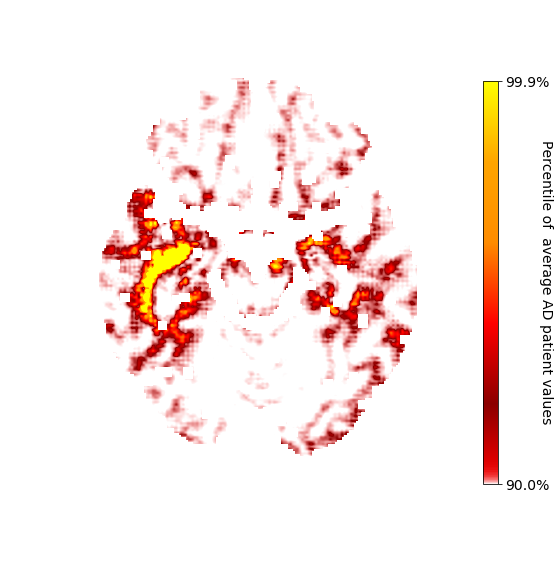

In [39]:
fig, ax = plot_idv_brain(maps[0], X_holdout[image_idx].squeeze(),
                            ref_scale=maps[0],
                            z_idx=61)

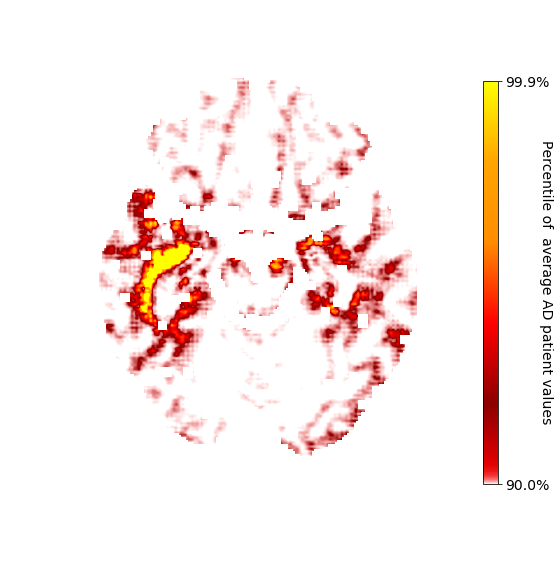

In [38]:
fig, ax = plot_idv_brain(maps[1], X_holdout[image_idx].squeeze(),
                            ref_scale=maps[0],
                            z_idx=61)

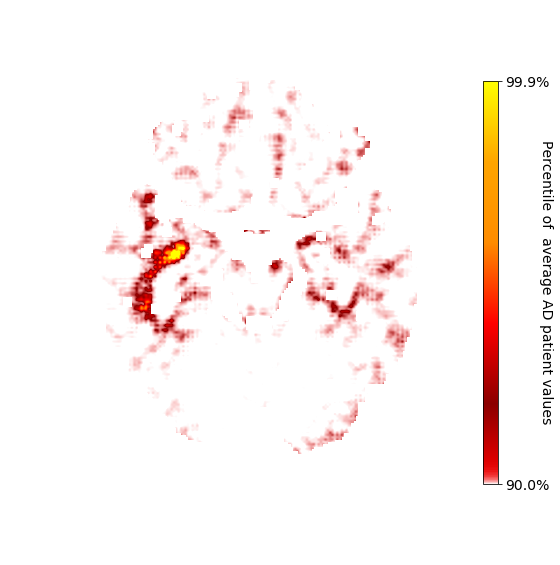

In [26]:
fig, ax = plot_idv_brain(maps[2], X_holdout[image_idx].squeeze(),
                            ref_scale=maps[0],
                            z_idx=60)

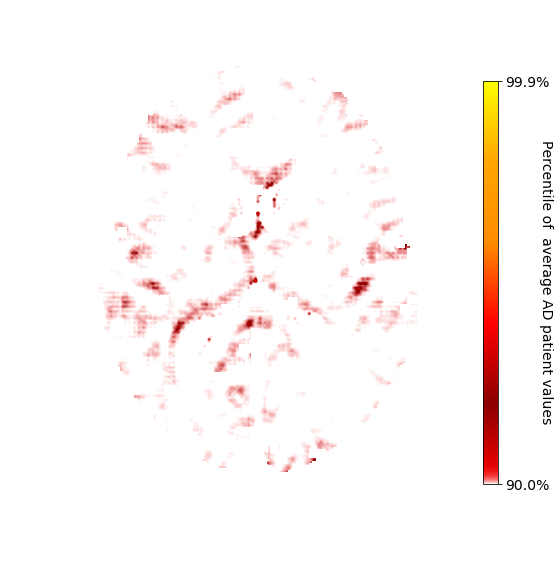

In [27]:
fig, ax = plot_idv_brain(maps[3], X_holdout[image_idx].squeeze(),
                            ref_scale=maps[0],
                            z_idx=90)

In [28]:
np.sum(np.abs(maps[0] - maps[1]))

0.12530407

In [29]:
np.sum(np.abs(maps[0] - maps[2]))

0.43455464

In [30]:
np.sum(np.abs(maps[0] - maps[-1]))

0.6774742

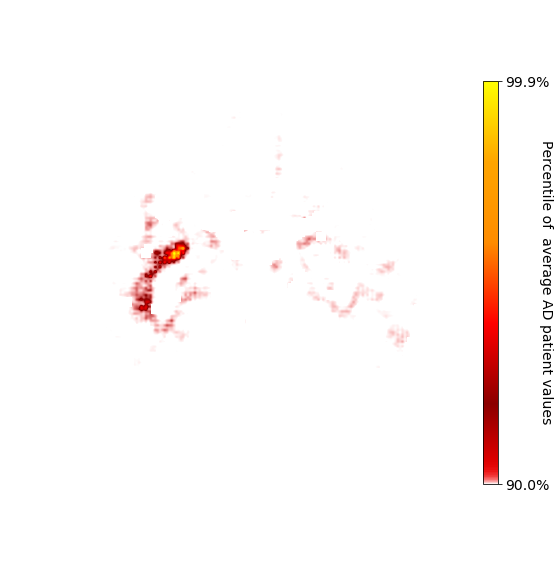

In [31]:
fig, ax = plot_idv_brain(np.abs(maps[0] - maps[1]), X_holdout[image_idx].squeeze(),
                            ref_scale=maps[0],
                            z_idx=60)

Absolute difference to non-randomized heatmap 0.0
Absolute difference to non-randomized heatmap 0.12530407309532166
Absolute difference to non-randomized heatmap 0.4345546364784241
Absolute difference to non-randomized heatmap 0.4974861145019531
Absolute difference to non-randomized heatmap 0.532514750957489
Absolute difference to non-randomized heatmap 0.6774742007255554


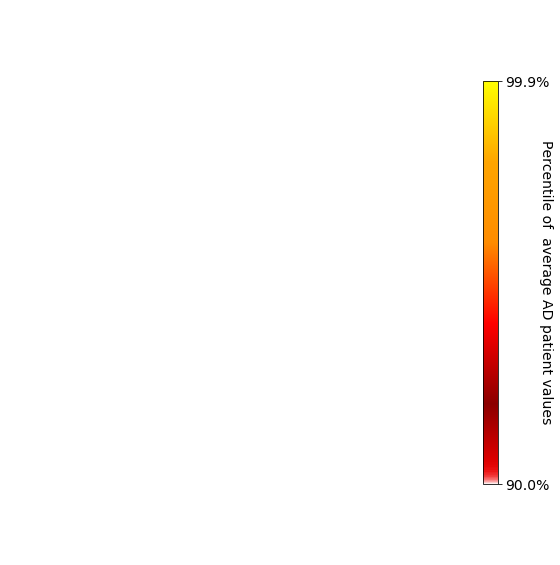

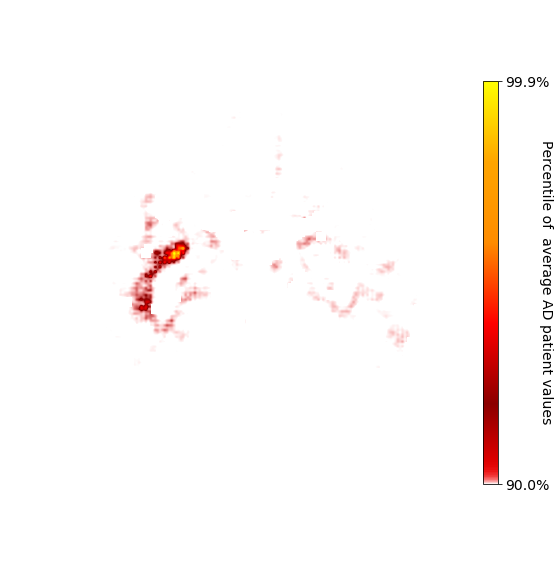

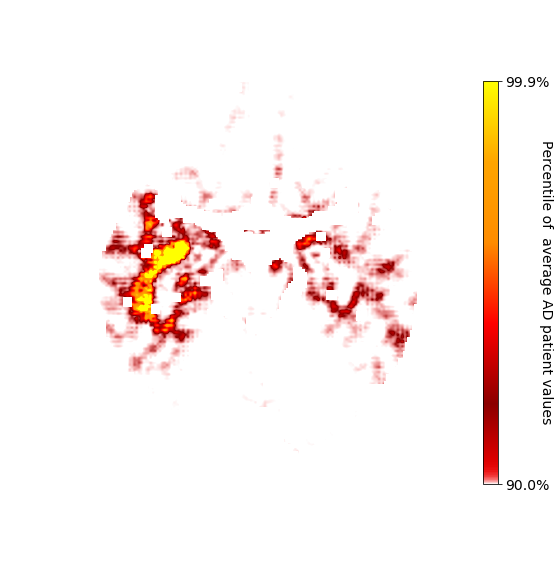

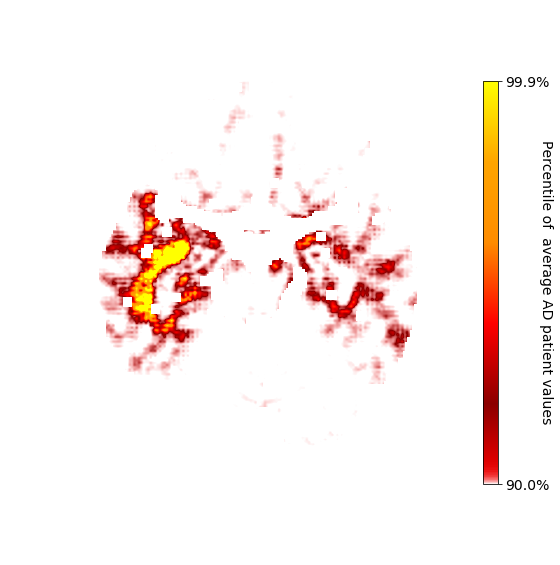

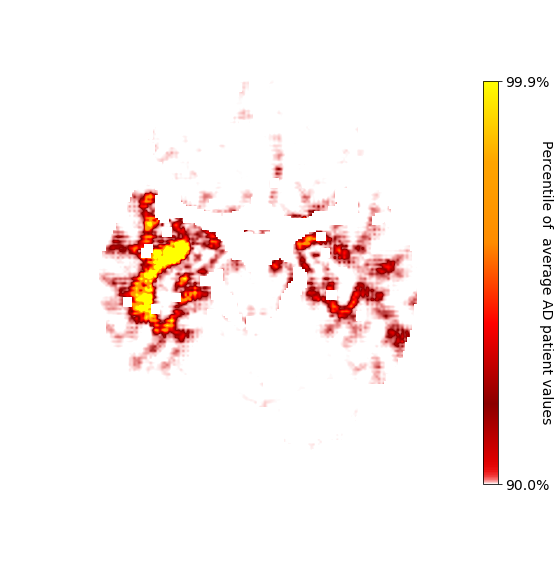

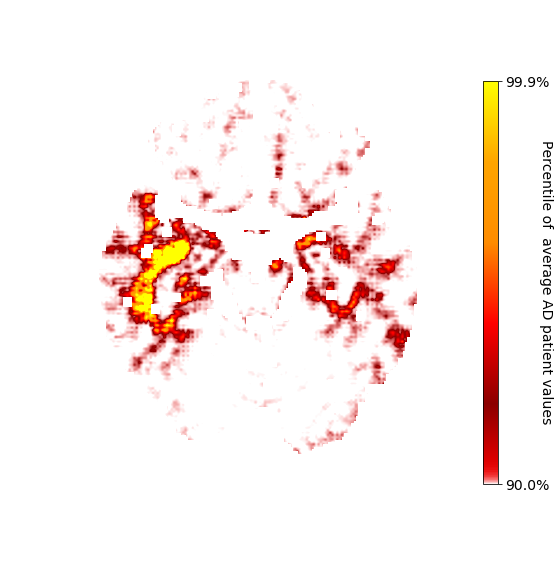

In [32]:
for map_m in maps:
    print("Absolute difference to non-randomized heatmap {}".format(np.sum(np.abs(maps[0] - map_m))))
    fig, ax = plot_idv_brain(np.abs(maps[0] - map_m), X_holdout[image_idx].squeeze(),
                            ref_scale=maps[0],
                            z_idx=60)

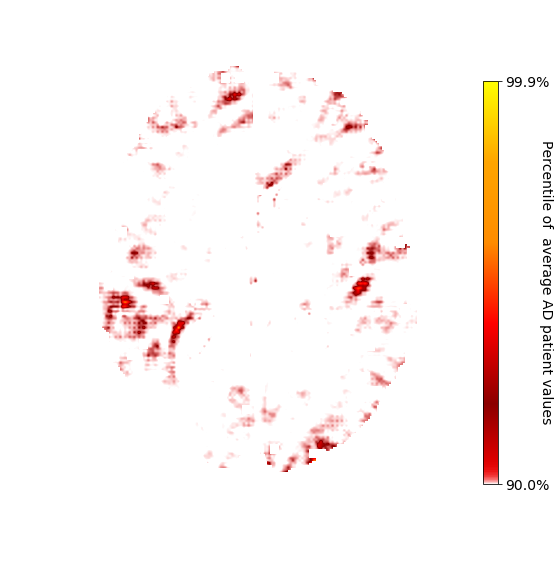

In [33]:
fig, ax = plot_idv_brain(maps[0] - maps[-1], X_holdout[image_idx].squeeze(),
                            ref_scale=maps[0],
                            z_idx=90)